# Cookie Problem

In [1]:
from __future__ import print_function

import numpy as np

%matplotlib inline

from tqdm import tqdm

import pickle
import numpy as np
from matplotlib import interactive, pyplot

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler


import GPy

import fenics as fe
import tt
from tt.cross import rect_cross

In [2]:
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.filterwarnings("ignore",category=DataConversionWarning)


def get_data(size, n, random_state=None):
    if random_state is None:
        random_state = np.random.RandomState()
    p = random_state.randint(n, size=size)

    y = solve_pde_exact(p, n, [0])
    indices = p.astype(int)
    return y, p, indices


def multiidx2idx(multiidx, size):
    idx = 0
    d = len(size)
    for i, s in enumerate(size[::-1]):
        idx += multiidx[d - i - 1] * s**i
    return idx


def idx2multiidx(idx, size):
    d = len(size)
    idx_copy = np.copy(idx)
    multiidx = np.empty((idx.shape[0], d), dtype=int)

    for i, s in enumerate(size[::-1]):
        multiidx[:, d - i - 1] = idx_copy % s
        idx_copy = (idx_copy - multiidx[:, d - i -1]) // s
        
    return multiidx


def calc_mse(y, x_tt, multiidx):
    error = 0
    for i, index in enumerate(multiidx):
        error += (y[i] - x_tt[index])**2

    error /= len(multiidx)
    return error

#### Necessray function to solve PDE

In [3]:
def boundary(x, on_boundary):
    return on_boundary

def solve(m, p):
    class CookieExpression(fe.Expression):
        def __init__(self, m, p, **kwargs):
            self.p = p
            self.m = m

        def eval(self, value, x):
            rho = 1.0 / (4 * self.m + 2)
            value[0] = 1.0
            for s in range(m):
                for t in range(m):
                    if (x[0] - rho * (4 * s + 3))**2 + (x[1] - rho * (4 * t + 3))**2 < rho**2:
                        mu = m * t + s
                        value[0] = 1 / self.p[mu]
                        return


    # Create mesh and define function space
    mesh = fe.UnitSquareMesh(20, 20)
    V = fe.FunctionSpace(mesh, 'P', 1)

    # Define boundary condition
    u_D = fe.Constant(0)

    bc = fe.DirichletBC(V, u_D, boundary)

    # Define variational problem
    u = fe.TrialFunction(V)
    v = fe.TestFunction(V)

    f = CookieExpression(m=m, p=p, degree=2)#, element=V.ufl_element())
    a = fe.dot(fe.grad(u), fe.grad(v)) * fe.dx
    L = f * v * fe.dx

    # Compute solution
    u = fe.Function(V)
    fe.solve(a == L, u, bc)
    return u, mesh

In [4]:
def u_average(u, mesh):
    n = int(np.sqrt(mesh.coordinates().shape[0]))
    h1 = mesh.coordinates()[1, 0] - mesh.coordinates()[0, 0]
    h2 = mesh.coordinates()[n, 1] - mesh.coordinates()[n - 1, 1]
    y = u.compute_vertex_values().reshape(n, n)
    x1 = y[:, :-1] + y[:, 1:]
    x2 = x1[:-1] + x1[1:]
    area = x2.sum() * h1 * h2 / 4
    return area

In [5]:
def solve_pde_exact(p, n, counter, scale=1):
    m = int(np.sqrt(p.shape[1]))
    p = p / float(n - 1) * scale + 0.5
    y = np.empty((p.shape[0], ), dtype=float)
    for i in range(p.shape[0]):
        u, mesh = solve(m, p[i])
        y[i] = u_average(u, mesh)
    counter[0] += p.shape[0]
    return y

### Define loss function

In [6]:
def build_graph(x_init, y_train, train_idx, y_test, test_idx):    
    estimated = t3f.get_variable('estimated', initializer=x_init)

    # Loss
    estimated_vals_train = t3f.gather_nd(estimated, train_idx)
    loss = tf.reduce_mean((estimated_vals_train - y_train) ** 2)
    
    estimated_vals_test = t3f.gather_nd(estimated, test_idx)    
    test_loss = tf.reduce_mean((estimated_vals_test - y_test)**2)
    return loss, test_loss, estimated

#### Training function

In [7]:
def train(loss, test_loss, estimated_tensor):
    optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
    step = optimizer.minimize(loss)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        loss_hist = []
        test_loss_hist = []

        for i in range(200):
            _, loss_v = sess.run([step, loss])
            loss_hist.append(loss_v)
            test_loss_hist.append(sess.run(test_loss))
        
        cores = sess.run(estimated_tensor.tt_cores)
        estimated_tensor_ttpy = tt.core.vector.tensor.from_list(cores)
        
    pyplot.figure()
    pyplot.plot(loss_hist, label='Train')
    pyplot.plot(test_loss_hist, label='Test')
    pyplot.legend()
    pyplot.show()
        
    return loss_hist, test_loss_hist, estimated_tensor_ttpy

In [8]:
def tensor_completion_rand_init(y_train, train_idx, y_test, test_idx, size):
    tf.reset_default_graph()

    d = train_idx.shape[1]
    x_init = t3f.random_tensor(size, tt_rank=4)

    loss, test_loss, estimated = build_graph(x_init, y_train, train_idx, y_test, test_idx)
    loss_hist, test_loss_hist, estimated_ttpy = train(loss, test_loss, estimated)

    error_test = calc_mse(y_test, estimated_ttpy, test_idx)
    error_train = calc_mse(y_train, estimated_ttpy, train_idx)
    
    return error_train, error_test, estimated_ttpy

### GP+TT-cross as init

In [14]:
def tensor_completion_gp_init(x_train, y_train, train_idx, y_test, test_idx, size):
    r = 2
    d = x_train.shape[1]


    kernel = GPy.kern.RBF(d)
    size = np.asarray(size)
    model = GPy.models.GPRegression(x_train / (size - 1), y_train, kernel)
    model.optimize()

    x0 = tt.rand(size, d, r)
    x = rect_cross.cross(lambda x: model.predict(x / (size - 1))[0], x0, nswp=2, kickrank=1, rf=2)

    tf.reset_default_graph()

    x_cores = tt.core.vector.tensor.to_list(x)
    x_cores = [core.astype(np.float32) for core in x_krr_cores]
    x_init = t3f.TensorTrain(x_krr_cores, size, x.r)

    loss, test_loss, estimated = build_graph(x_init, y_train, train_idx, y_test, test_idx)
    loss_hist, test_loss_hist, estimated_ttpy = train(loss, test_loss, estimated)

    error_test = calc_mse(y_test, estimated_ttpy, test_idx)
    error_train = calc_mse(y_train, estimated_ttpy, train_idx)
    
    return error_train, error_test, model, x

# Random init vs GP init for Tensor Completion

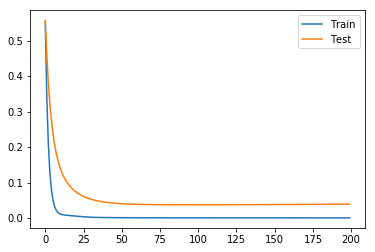

swp: 0/1 er_rel = 4.3e+02 er_abs = 4.0e+05 erank = 4.0 fun_eval: 1380
swp: 1/1 er_rel = 1.7e-02 er_abs = 1.6e+01 erank = 6.4 fun_eval: 5330


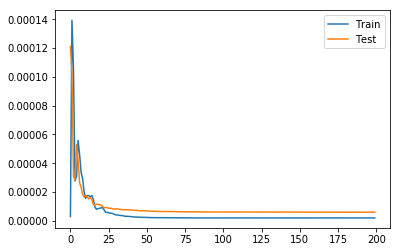

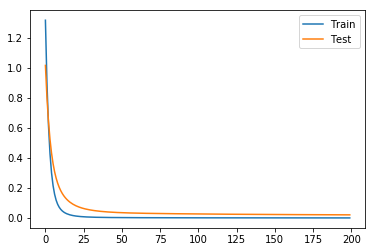

swp: 0/1 er_rel = 4.5e+02 er_abs = 4.2e+05 erank = 4.0 fun_eval: 1380
swp: 1/1 er_rel = 1.8e-02 er_abs = 1.7e+01 erank = 6.5 fun_eval: 5240


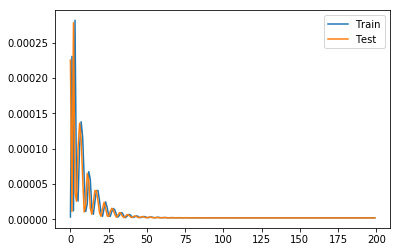

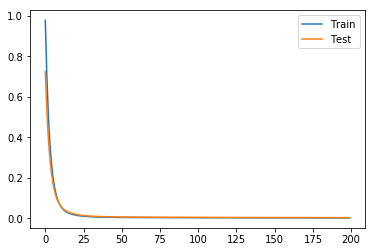

swp: 0/1 er_rel = 5.3e+02 er_abs = 4.9e+05 erank = 4.0 fun_eval: 1380
swp: 1/1 er_rel = 4.0e-02 er_abs = 3.9e+01 erank = 6.6 fun_eval: 5390


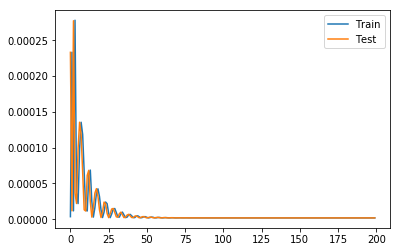

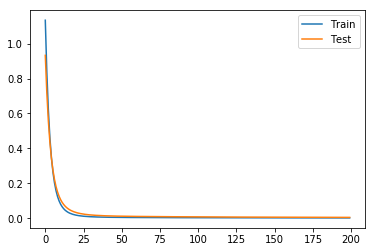

swp: 0/1 er_rel = 3.4e+02 er_abs = 3.2e+05 erank = 4.0 fun_eval: 1380
swp: 1/1 er_rel = 6.1e-03 er_abs = 5.7e+00 erank = 6.0 fun_eval: 5080


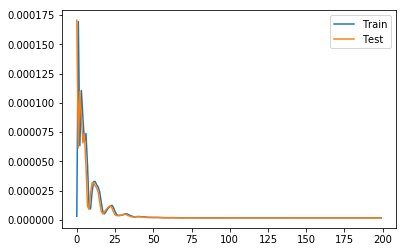

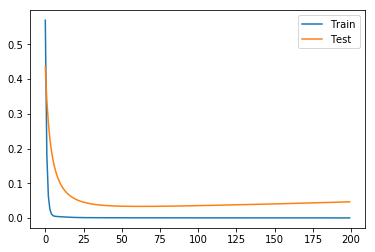

swp: 0/1 er_rel = 2.5e+03 er_abs = 7.5e+09 erank = 4.0 fun_eval: 2640
swp: 1/1 er_rel = 3.6e-02 er_abs = 1.1e+05 erank = 6.9 fun_eval: 10920


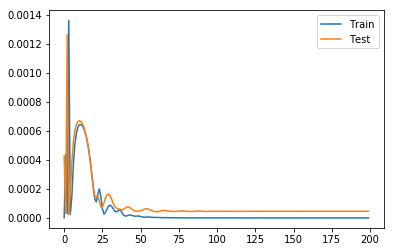

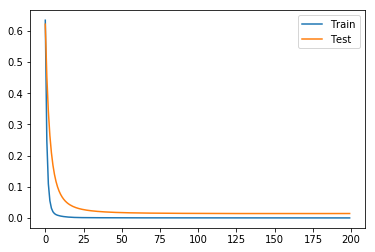

swp: 0/1 er_rel = 3.9e+03 er_abs = 1.2e+10 erank = 4.0 fun_eval: 2640
swp: 1/1 er_rel = 4.8e-02 er_abs = 1.4e+05 erank = 6.3 fun_eval: 10390


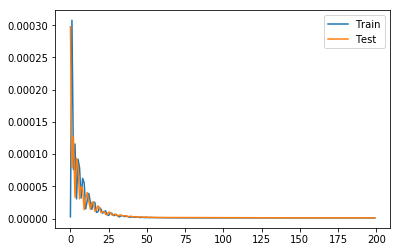

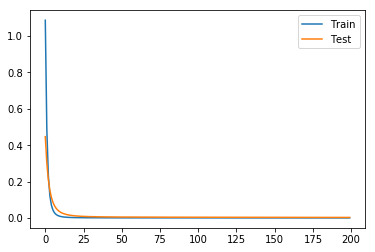

swp: 0/1 er_rel = 2.4e+03 er_abs = 7.3e+09 erank = 4.0 fun_eval: 2640
swp: 1/1 er_rel = 3.8e-02 er_abs = 1.2e+05 erank = 6.5 fun_eval: 10390


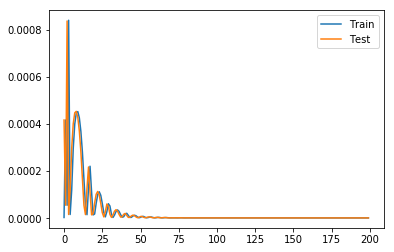

In [ ]:
random_state = np.random.RandomState(42)

train_size_list = [300, 1000, 5000, 10000]

m_list = [3, 4]

n = 10
r = 2

errors_rand = {'mse_train': [], 'mse_test': [], 'rel_train': [], 'rel_test': []}
errors_gp = {'mse_train': [], 'mse_test': [], 'rel_train': [], 'rel_test': [],
             'model_mse_train': [], 'model_mse_test': [],
             'model_rel_train': [], 'model_rel_test': [],
             'init_mse_train': [], 'init_mse_test': [],
             'init_rel_train': [], 'init_rel_test': []}

for m in m_list:
    for train_size in train_size_list:
        
        d = int(m**2)
        n = int(n)
        train_size = int(train_size)
        size = [n for _ in range(d)]

        try:
            y_train = np.load('y_train100_{}_{}_{}.npy'.format(d, int(n), int(train_size)))
            p_train = np.load('p_train100_{}_{}_{}.npy'.format(d, int(n), int(train_size)))
            indices_train = np.load('indices_train100_{}_{}_{}.npy'.format(d, int(n), int(train_size)))
        except:
            y_train, p_train, indices_train = get_data((train_size, d), n, random_state=random_state)
            np.save('y_train100_{}_{}_{}.npy'.format(d, int(n), int(train_size)), y_train)
            np.save('p_train100_{}_{}_{}.npy'.format(d, int(n), int(train_size)), p_train)
            np.save('indices_train100_{}_{}_{}.npy'.format(d, int(n), int(train_size)), indices_train)

        try:
            y_test = np.load('y_test100_{}_{}.npy'.format(d, n))
            p_test = np.load('p_test100_{}_{}.npy'.format(d, n))
            indices_test = np.load('indices_test100_{}_{}.npy'.format(d, n))
        except:
            y_test, p_test, indices_test = get_data((5000, d), n, random_state=random_state)
            np.save('y_test100_{}_{}.npy'.format(d, n), y_test)
            np.save('p_test100_{}_{}.npy'.format(d, n), p_test)
            np.save('indices_test100_{}_{}.npy'.format(d, n), indices_test)

        y_train = y_train.reshape(-1, 1)
        y_test = y_test.reshape(-1, 1)
            
        # Make tensor completion using random init
        results_rand = tensor_completion_rand_init(y_train, indices_train, y_test, indices_test, size)

        # Make tensor completion using KRR+TT-cross as init
        results_gp = tensor_completion_krr_init(p_train, y_train, indices_train,
                                                 y_test, indices_test, size)

        model_gp = results_gp[2]
        x_gp = results_gp[3]
        for i, mode in enumerate(['train', 'test']):
            errors_rand['mse_' + mode].append(results_rand[i])
            errors_rand['rel_' + mode].append(np.sqrt(results_rand[i]) / y_test.std())

            errors_gp['mse_' + mode].append(results_gp[i ])
            errors_gp['rel_' + mode].append(np.sqrt(results_gp[i]) / y_test.std())

            if mode == 'train':
                gp_pr = model_krr.predict(p_train / (np.asarray(size) - 1))[0]
                y_truth = y_train
                indices_truth = indices_train
            else:
                krr_pr = model_krr.predict(p_test / (np.asarray(size) - 1))[0]
                y_truth = y_test
                indices_truth = indices_test

            errors_gp['model_mse_' + mode].append(mean_squared_error(y_truth, gp_pr))
            errors_gp['init_mse_' + mode].append(calc_mse(y_truth, x_gp, indices_truth))
            
            errors_gp['model_rel_' + mode].append(np.sqrt(errors_gp['model_mse_' + mode][-1]) / y_test.std())
            errors_gp['init_rel_' + mode].append(np.sqrt(errors_gp['init_mse_' + mode][-1]) / y_test.std())

#### Save errors

In [12]:
import pickle
with open('Cookie_tensor_completion_errors_rand.pkl', 'wb') as f:
    pickle.dump(errors_rand, f)

with open('Cookie_tensor_completion_errors_gp.pkl', 'wb') as f:
    pickle.dump(errors_gp, f)

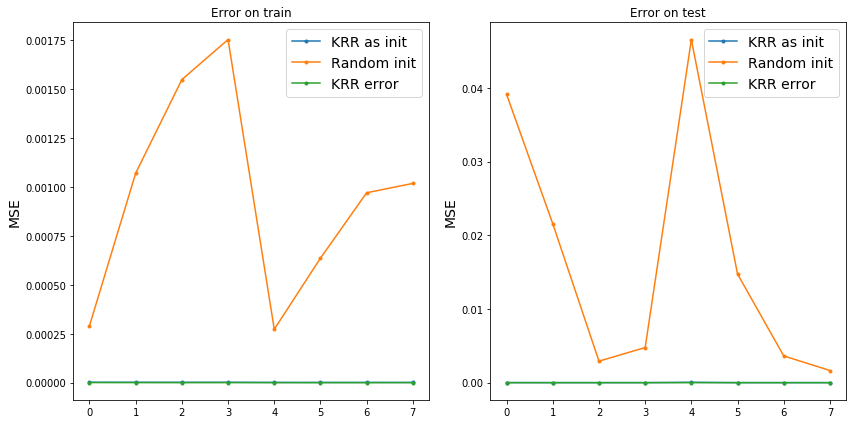

In [13]:
figure = pyplot.figure(figsize=(12, 6))
for i, mode in enumerate(['train', 'test']):
    ax = figure.add_subplot(1, 2, i + 1)
    ax.plot(errors_gp['mse_' + mode], '.-', label='GP as init')
    ax.plot(errors_rand['mse_' + mode], '.-', label='Random init')
    ax.plot(errors_gp['model_mse_' + mode], '.-', label='GP error')
    ax.set_ylabel('MSE', fontsize=14)
    ax.legend(loc='best', fontsize=14)
    ax.set_title('Error on {}'.format(mode))
figure.tight_layout()
pyplot.show()

#### Load errors

In [4]:
import pickle
with open('Cookie100_krr_as_init_errors_rand.pkl', 'rb') as f:
    errors_rand = pickle.load(f)

with open('Cookie100_krr_as_init_errors_krr.pkl', 'rb') as f:
    errors_krr = pickle.load(f)

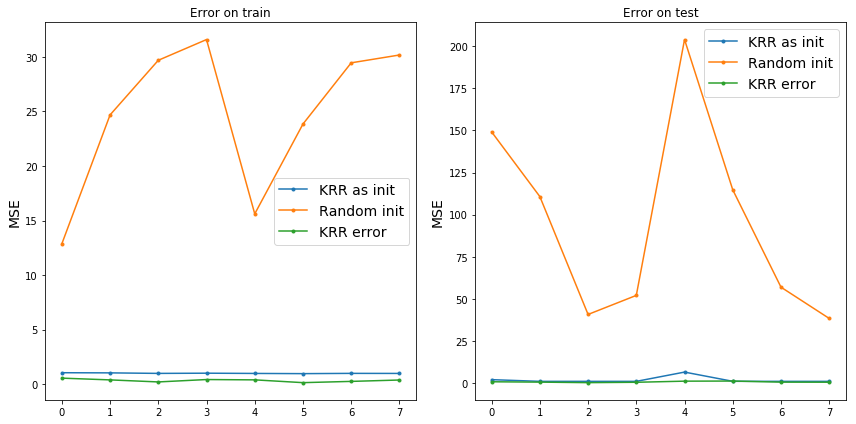

In [14]:
figure = pyplot.figure(figsize=(12, 6))
for i, mode in enumerate(['train', 'test']):
    ax = figure.add_subplot(1, 2, i + 1)
    ax.plot(errors_krr['rel_' + mode], '.-', label='KRR as init')
    ax.plot(errors_rand['rel_' + mode], '.-', label='Random init')
    ax.plot(errors_krr['model_rel_' + mode], '.-', label='KRR error')
    pyplot.ylabel('RMSE / y_std', fontsize=14)
    ax.legend(loc='best', fontsize=14)
    ax.set_title('Error on {}'.format(mode))
figure.tight_layout()
pyplot.show()

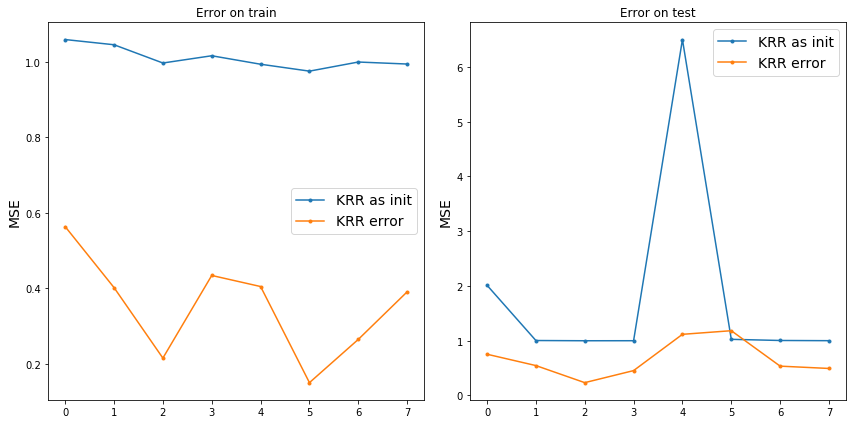

In [5]:
figure = pyplot.figure(figsize=(12, 6))
for i, mode in enumerate(['train', 'test']):
    ax = figure.add_subplot(1, 2, i + 1)
    ax.plot(errors_krr['rel_' + mode], '.-', label='KRR as init')
    # ax.plot(errors_rand['rel_' + mode], '.-', label='Random init')
    ax.plot(errors_krr['model_rel_' + mode], '.-', label='KRR error')
    pyplot.ylabel('RMSE / y_std', fontsize=14)
    ax.set_ylabel('MSE', fontsize=14)
    ax.legend(loc='best', fontsize=14)
    ax.set_title('Error on {}'.format(mode))
figure.tight_layout()
pyplot.show()

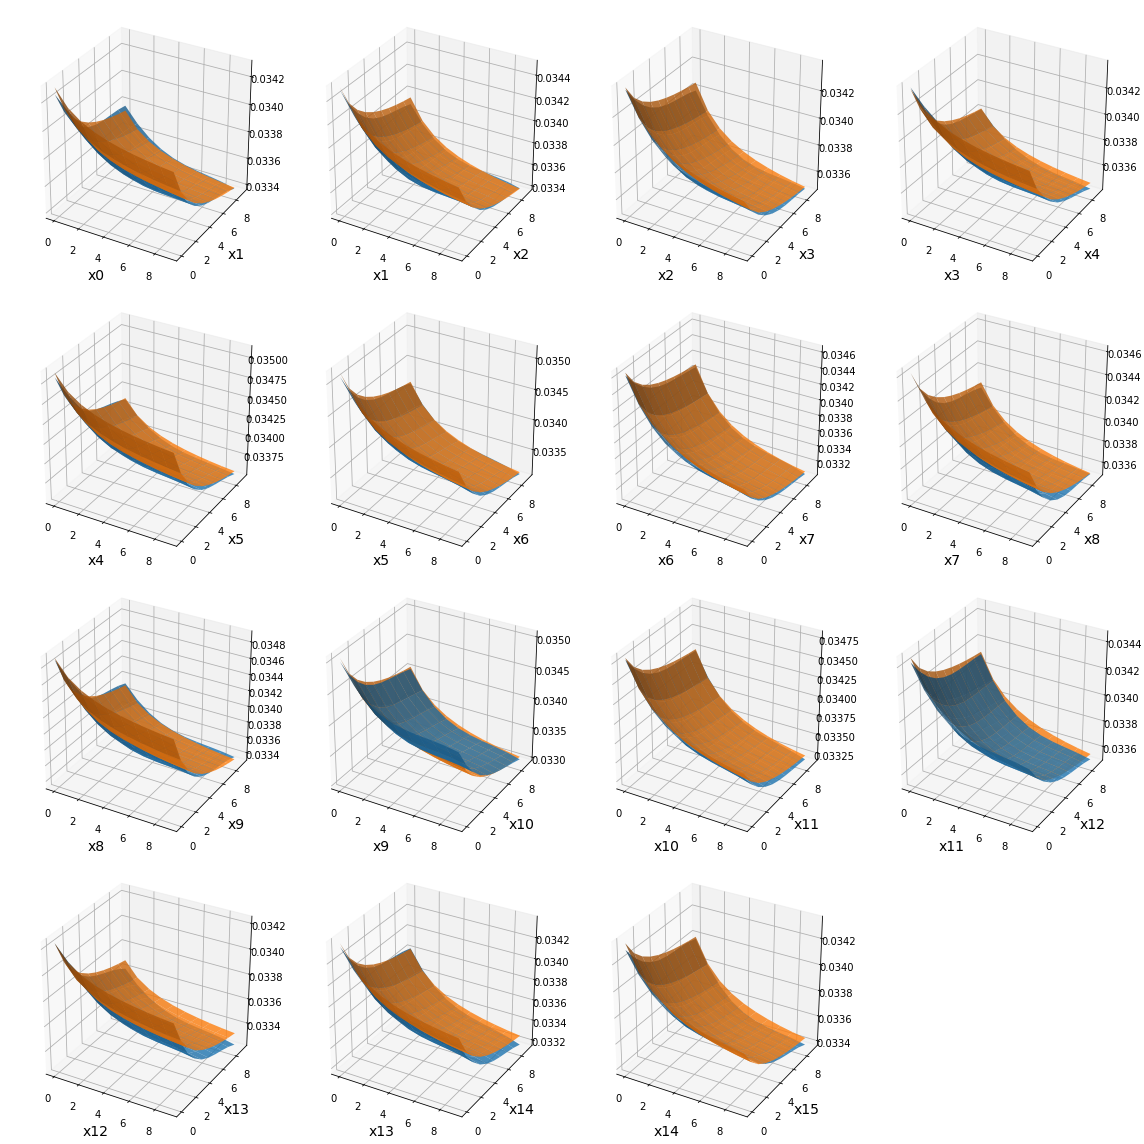

In [27]:
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D

np.random.seed(42)
value = np.random.randint(n, size=(1, p_train.shape[1]))

figure = pyplot.figure(figsize=(16, 16))
m = int(np.sqrt(d))
for i in range(p_train.shape[1]):
    for j in range(i + 1, min(i + 2, p_train.shape[1])):  # p_train.shape[1]):
        idx = [i, j]

        plot_size = n
        dim = 2

        x0 = np.tile(value, (plot_size**dim, 1))
        XY = np.meshgrid(np.arange(n), np.arange(n))
        x_grid = np.hstack([XY[0].reshape(-1, 1), XY[1].reshape(-1, 1)])
        x0[:, idx] = x_grid
        
        y_exact = solve_pde_exact(x0, n, [0])
        y_pr = model_krr.predict(x0)

        ax = figure.add_subplot(m, m, i + 1, projection='3d')
        ax.plot_surface(XY[0], XY[1], y_pr.reshape(plot_size, plot_size), alpha=0.8)
        ax.plot_surface(XY[0], XY[1], y_exact.reshape(plot_size, plot_size), alpha=0.8)
        
        ax.set_xlabel('x{}'.format(i), fontsize=14)
        ax.set_ylabel('x{}'.format(j), fontsize=14)
figure.tight_layout()
pyplot.show()

# Random init vs. GP init for TT-cross (black-box)

In [ ]:
random_state = np.random.RandomState(42)

# train_size_list = [300, 1000, 5000, 10000]
train_size_list = [5000]

m_list = [4]

n = 10
r = 2

errors_gp_as_init = {'fun_evals': [], 'mse': []}
errors_bb = {'fun_evals': [], 'mse': []}
for m in m_list:
    for train_size in train_size_list:
        
        d = int(m**2)
        n = int(n)
        train_size = int(train_size)
        size = [n for _ in range(d)]

        try:
            y_train = np.load('y_train100_{}_{}_{}.npy'.format(d, int(n), int(train_size)))
            p_train = np.load('p_train100_{}_{}_{}.npy'.format(d, int(n), int(train_size)))
            indices_train = np.load('indices_train100_{}_{}_{}.npy'.format(d, int(n), int(train_size)))
        except:
            y_train, p_train, indices_train = get_data((train_size, d), n, random_state=random_state)
            np.save('y_train100_{}_{}_{}.npy'.format(d, int(n), int(train_size)), y_train)
            np.save('p_train100_{}_{}_{}.npy'.format(d, int(n), int(train_size)), p_train)
            np.save('indices_train100_{}_{}_{}.npy'.format(d, int(n), int(train_size)), indices_train)

        try:
            y_test = np.load('y_test100_{}_{}.npy'.format(d, n))
            p_test = np.load('p_test100_{}_{}.npy'.format(d, n))
            indices_test = np.load('indices_test100_{}_{}.npy'.format(d, n))
        except:
            y_test, p_test, indices_test = get_data((5000, d), n, random_state=random_state)
            np.save('y_test100_{}_{}.npy'.format(d, n), y_test)
            np.save('p_test100_{}_{}.npy'.format(d, n), p_test)
            np.save('indices_test100_{}_{}.npy'.format(d, n), indices_test)

        y_train = y_train.reshape(-1, 1)
        y_test = y_test.reshape(-1, 1)
            
        # Make tensor completion using GP+TT-cross as init
        kernel = GPy.kern.RBF(d)
        size = np.asarray(size)
        model = GPy.models.GPRegression(p_train / (size - 1), y_train, kernel)
        model.optimize(messages=True)

        x0 = tt.rand(size, d, r)
        x0 = rect_cross.cross(lambda x: model.predict(x / (size - 1))[0], x0, nswp=2, kickrank=1, rf=2)

        fun_evals = [0]
        x_gp_as_init = rect_cross.cross(lambda x: solve_pde_exact(x, n, fun_evals), x0, nswp=5, kickrank=1, rf=2)

        # 
        x0 = tt.rand(size, d, r)
        fun_evals_bb = [0]
        x_bb = rect_cross.cross(lambda x: solve_pde_exact(x, n, fun_evals_bb), x0, nswp=5, kickrank=1, rf=2)
        
        errors_gp_as_init['mse'].append(calc_mse(y_test, x_gp_as_init, indices_test))
        errors_gp_as_init['fun_evals'].append(fun_evals[0])
        
        errors_bb['mse'].append(calc_mse(y_test, x_bb, indices_test))
        errors_bb['fun_evals'].append(fun_evals_bb[0])
        
        print(errors_gp_as_init['mse'][-1], fun_evals)
        print(errors_bb['mse'][-1], fun_evals_bb)
        
#         model_gp = results_gp[2]
#         x_gp = results_gp[3]
#         for i, mode in enumerate(['train', 'test']):
#             errors_rand['mse_' + mode].append(results_rand[i])
#             errors_rand['rel_' + mode].append(np.sqrt(results_rand[i]) / y_test.std())

#             errors_gp['mse_' + mode].append(results_gp[i ])
#             errors_gp['rel_' + mode].append(np.sqrt(results_gp[i]) / y_test.std())

#             if mode == 'train':
#                 gp_pr = model_krr.predict(p_train / (np.asarray(size) - 1))[0]
#                 y_truth = y_train
#                 indices_truth = indices_train
#             else:
#                 krr_pr = model_krr.predict(p_test / (np.asarray(size) - 1))[0]
#                 y_truth = y_test
#                 indices_truth = indices_test

#             errors_gp['model_mse_' + mode].append(mean_squared_error(y_truth, gp_pr))
#             errors_gp['init_mse_' + mode].append(calc_mse(y_truth, x_gp, indices_truth))
            
#             errors_gp['model_rel_' + mode].append(np.sqrt(errors_gp['model_mse_' + mode][-1]) / y_test.std())
#             errors_gp['init_rel_' + mode].append(np.sqrt(errors_gp['init_mse_' + mode][-1]) / y_test.std())

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    20s17  0006  -2.794617e+04   2.233001e+06 
 01m03s88  0019  -2.931077e+04   6.460103e+02 
 01m44s40  0031  -2.940340e+04   1.604631e+00 
 01m57s86  0035  -2.940341e+04   2.989207e-05 
Runtime:  01m57s86
Optimization status: Converged

swp: 0/1 er_rel = 3.5e+03 er_abs = 1.1e+10 erank = 4.0 fun_eval: 2640
swp: 1/1 er_rel = 1.4e-02 er_abs = 4.3e+04 erank = 6.4 fun_eval: 10260
swp: 0/4 er_rel = 1.5e-01 er_abs = 5.5e+05 erank = 11.2 fun_eval: 21200


In [ ]:
x0 = tt.rand(size, d, r)
fun_evals_bb = [0]
x_bb = rect_cross.cross(lambda x: solve_pde_exact(x, n, fun_evals_bb), x0, nswp=5, kickrank=1, rf=2)

errors = calc_mse(y_test, x1, indices_test)
errors_bb = calc_mse(y_test, x_bb, indices_test)